In [1]:
import pandas as pd
import numpy as np
from random import shuffle

In [2]:
df = pd.read_csv("../data/subplot.csv")
df = df.drop('IMAGERY_TITLE', axis = 1)
df = df.dropna(axis = 0)
plot_ids = set(df['PLOT_ID'])
#df['TREE'][df['TREE'] == 'No'] = 0
#df['TREE'][df['TREE'] == 'Yes'] = 1
df.shape[0]/196

112.0

In [3]:
def calc_bbox(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    # TOP, LEFT, BOTTOM, RIGHT
    # (min x, min y), (max x, max y)
    return [(min(subs['LON']), min(subs['LAT'])), (max(subs['LON']), max(subs['LAT']))]

locations = [calc_bbox(x) for x in plot_ids]
locations[0]

[(39.499457864411035, 14.078345324474359),
 (39.50062567428038, 14.079478055220802)]

In [4]:
def reconstruct_images(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows


def reconstruct_images_categorical(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    positive = []
    negative = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        tree = subs_lat['TREE']
        background = [1 - x for x in tree]
        positive.append(tree)
        negative.append(background)
    total = np.stack((positive, negative))
    return total

data = [reconstruct_images(x) for x in plot_ids]

In [5]:
def remove_blank_steps(array):
    to_update = {}
    sets = []
    for k in range(6):
        for i in range(array.shape[0]):
            for k in range(array.shape[-1]):
                mean = (np.mean(array[i, :, :, k]))
                if mean == 0:
                    sets.append(i)
                    if i < array.shape[0] - 1:
                        array[i, :, :, k] = array[i + 1, :, :, k]
                    else:
                        array[i, :, :, k] = array[i - 1, :, :, k]
                if mean == 1:
                    sets.append(i)
                    if i < array.shape[0] - 1:
                        array[i, :, :, k] = array[i + 1, :, :, k]
                    else:
                        array[i, :, :, k] = array[i - 1, :, :, k]
    for i in range(array.shape[0]):
        for k in range(array.shape[-1]):
            mean = (np.mean(array[i, :, :, k]))
            if mean == 0:
                if i < array.shape[0] - 2:
                    array[i, :, :, k] = array[i + 2, :, :, k]
                else:
                    array[i, :, :, k] = array[i - 2, :, :, k]
            if mean == 1:
                if i < array.shape[0] - 2:
                    array[i, :, :, k] = array[i + 2, :, :, k]
                else:
                    array[i, :, :, k] = array[i - 2, :, :, k]
    print(set(sets))
    return array

In [6]:
import os
sorted_files = [str(x) + ".npy" for x in range(0, 112)]
image_size = 14

def ndvi(x):
    # (B8 - B4)/(B8 + B4)
    ndvis = [(im[:, :, 6] - im[:, :, 2]) / (im[:, :, 6] + im[:, :, 2]) for im in x]
    min_ndvi = min([np.mean(x) for x in ndvis])
    max_ndvi = max([np.mean(x) for x in ndvis])
    ndvis = [(x - min_ndvi / (max_ndvi - min_ndvi)) for x in ndvis]
    x_padding = np.zeros((x.shape[0], image_size, image_size, 1))
    x = np.concatenate((x, x_padding), axis = 3)
    # Iterate over each time step and add NDVI in as the 11th channel
    for i in range(x.shape[0]):
        x[i, :, :, 10] = ndvis[i]
    return x

# Initiate empty lists to store the X and Y data in
data_x = []
data_y = []
data_location_x = []
data_location_y = []

# Iterate over each plot
pad = True
flip = True
for i in sorted_files:
    # Load the sentinel imagery
    x = np.load("../data/processed/" + i)
    i = int(i[:-4])
    # Shape check
    if x.shape[1] == image_size:
        x = ndvi(x)                # calc NDVI
        x = remove_blank_steps(x)
        y = data[i]
        #x = np.median(x, axis = 0) # and calculate the median over the time steps
        if pad:
            if x.shape[0] < 24:
                print(x.shape[0])
                padding = np.zeros((24 - x.shape[0], image_size, image_size, 11))
                x = np.concatenate((x, padding), axis = 0)
        data_x.append(x)
        data_y.append(y)
        if flip:
                # FLIP HORIZONTAL
            x1 = np.flip(x, 1)
            data_x.append(x1)
            data_y.append(np.flip(y, 1))
                # FLIP BOTH
            x2 = np.flip(x, 2)
            x2 = np.flip(x2, 1)
            data_x.append(x2)
            data_y.append(np.flip(y, [0, 1]))
                # FLIP VERTICAL
            x3 = np.flip(x, 2)
            data_x.append(x3)
            data_y.append(np.flip(y, 1))

data_x = np.stack(data_x)
data_y = np.stack(data_y)
data_y = np.reshape(data_y, (112*4, 14, 14, 1))

set()
set()
set()
set()
set()
set()
set()
{6, 8, 9, 22, 23}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{1, 2, 19}
set()
set()
{10, 12, 13}
set()
set()
set()
set()
set()
set()
set()
set()
set()
{3, 4, 21}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


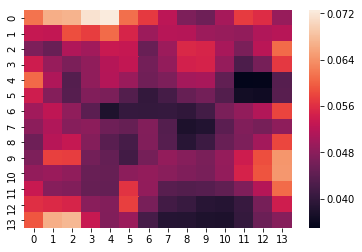

In [326]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(data_x[20, 4, :, :, 0]) # time 1, 

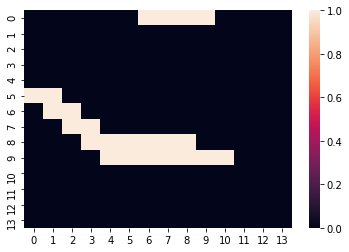

In [325]:
sns.heatmap(data[20])

In [9]:
train_x = data_x[:int(len(data_x) * 0.75)]
train_y = data_y[:int(len(data_x) * 0.75)]

test_x = data_x[int(len(data_x) * 0.75):]
test_y = data_y[int(len(data_x) * 0.75):]

In [10]:
from keras import backend as K
import tensorflow as tf

def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed

Using TensorFlow backend.


In [11]:
class ConvGRUCell(tf.nn.rnn_cell.RNNCell):
  """A GRU cell with convolutions instead of multiplications."""

  def __init__(self, shape, filters, kernel, activation=tf.tanh, normalize=False, data_format='channels_last', reuse=None):
    super(ConvGRUCell, self).__init__(_reuse=reuse)
    self._filters = filters
    self._kernel = kernel
    self._activation = activation
    self._normalize = normalize
    if data_format == 'channels_last':
        self._size = tf.TensorShape(shape + [self._filters])
        self._feature_axis = self._size.ndims
        self._data_format = None
    elif data_format == 'channels_first':
        self._size = tf.TensorShape([self._filters] + shape)
        self._feature_axis = 0
        self._data_format = 'NC'
    else:
        raise ValueError('Unknown data_format')

  @property
  def state_size(self):
    return self._size

  @property
  def output_size(self):
    return self._size

  def call(self, x, h):
    channels = x.shape[self._feature_axis].value

    with tf.variable_scope('gates'):
      inputs = tf.concat([x, h], axis=self._feature_axis)
      n = channels + self._filters
      m = 2 * self._filters if self._filters > 1 else 2
      W = tf.get_variable('kernel', self._kernel + [n, m])
      y = tf.nn.convolution(inputs, W, 'SAME', data_format=self._data_format)
      if self._normalize:
        r, u = tf.split(y, 2, axis=self._feature_axis)
        r = tf.contrib.layers.layer_norm(r)
        u = tf.contrib.layers.layer_norm(u)
      else:
        y += tf.get_variable('bias', [m], initializer=tf.ones_initializer())
        r, u = tf.split(y, 2, axis=self._feature_axis)
      r, u = tf.sigmoid(r), tf.sigmoid(u)

    with tf.variable_scope('candidate'):
      inputs = tf.concat([x, r * h], axis=self._feature_axis)
      n = channels + self._filters
      m = self._filters
      W = tf.get_variable('kernel', self._kernel + [n, m])
      y = tf.nn.convolution(inputs, W, 'SAME', data_format=self._data_format)
      if self._normalize:
        y = tf.contrib.layers.layer_norm(y)
      else:
        y += tf.get_variable('bias', [m], initializer=tf.zeros_initializer())
      h = u * h + (1 - u) * self._activation(y)

    return h, h

In [12]:
import keras
from keras.models import Sequential, Model
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import *
from keras.layers import Flatten, Dense, Input
from keras.layers import Lambda
from keras import regularizers

tf.reset_default_graph()
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

def conv_lstm_model():
    inp = Input(shape = (24, 14, 14, 11))
    #state = Bidirectional(ConvLSTM2D(filters=16, kernel_size=(2, 2),
    #              padding='same', return_sequences=False, recurrent_dropout = 0.25))(inp)
    
    cell = ConvGRUCell(shape = [14, 14],
                       filters = 128,
                       kernel = [3,3])
    
    #cell = tf.contrib.rnn.DropoutWrapper(
    #    cell, 
    #    input_keep_prob = 0.95,
    #)
    
    # Convolutional GRU Keras layer
    state = Lambda(
        lambda x: tf.concat(
            tf.nn.bidirectional_dynamic_rnn(
                cell, cell, x, dtype = tf.float32)[1], -1
            )
        )(inp)
    padded_inputs = ReflectionPadding2D((1, 1))(state)
    fm = Conv2D(filters = 1,
                kernel_size = (3, 3), 
                padding = 'valid',
                activation = 'sigmoid',
                #kernel_regularizer = regularizers.l1(0.001)
                )(padded_inputs)
    mod = Model(inputs = [inp],  outputs = fm)
    mod.summary()
    mod.compile(loss=[binary_focal_loss(alpha=0.15, gamma=2)],
                optimizer= keras.optimizers.Adam(lr=0.01),  metrics=['accuracy'])
    #mod.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return mod

m = conv_lstm_model()

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 14, 14, 11)    0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 14, 14, 256)       0         
_________________________________________________________________
reflection_padding2d_1 (Refl (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 1)         2305      
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
______________________________________________

In [347]:
m.fit(train_x,
      train_y, 
      validation_data = ((test_x, test_y)),
      batch_size=10,
      epochs = 200,
)

Train on 336 samples, validate on 112 samples
Epoch 1/200
336/336 [==============================] - 20s - loss: 25.8146 - acc: 0.9329 - val_loss: 58.0280 - val_acc: 0.8760
Epoch 2/200
336/336 [==============================] - 21s - loss: 25.6429 - acc: 0.9312 - val_loss: 53.2460 - val_acc: 0.8761
Epoch 3/200
336/336 [==============================] - 21s - loss: 26.3548 - acc: 0.9324 - val_loss: 71.2789 - val_acc: 0.8757
Epoch 4/200
336/336 [==============================] - 21s - loss: 25.5090 - acc: 0.9320 - val_loss: 59.1672 - val_acc: 0.8759
Epoch 5/200
336/336 [==============================] - 21s - loss: 25.9352 - acc: 0.9316 - val_loss: 61.3671 - val_acc: 0.8757
Epoch 6/200
336/336 [==============================] - 22s - loss: 25.6332 - acc: 0.9320 - val_loss: 62.0950 - val_acc: 0.8758
Epoch 7/200
336/336 [==============================] - 27s - loss: 25.6277 - acc: 0.9340 - val_loss: 56.1417 - val_acc: 0.8761
Epoch 8/200
336/336 [==============================] - 21s - loss

KeyboardInterrupt: 

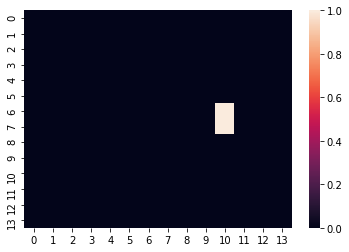

In [524]:
# 4 looks good, 0, 76, 90, 96, 108, 22, 56, 63

sns.heatmap(train_y[328].reshape(14, 14))

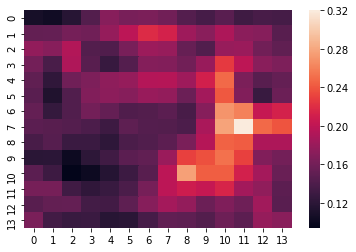

In [525]:
pred = m.predict(train_x[328].reshape(1, 24, 14, 14, 11))
pred = pred.reshape(14, 14)
#pred[np.where(pred > 0.5)] = 1
#pred[np.where(pred < 0.5)] = 0


sns.heatmap(pred)

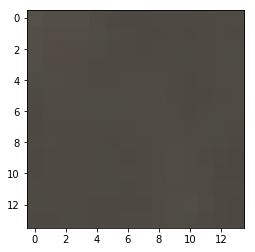

In [530]:
#sns.heatmap(train_x[76, 21, :, :, 10])
plt.imshow(train_x[328][3][:, :, [3, 2, 1]] + 0.15)

In [522]:
#((int(len(data_x) * 0.75) + 108) / 4)
330/4

82.5

In [523]:
df['PLOT_ID'].unique()[82]

135191230